# Optimization via simple differential evolution
The classic DE algorithm, shown in Algorithm 2 in our paper, is implemented in our own package [DifferentialEvolution](https://github.com/ShuhuaGao/DifferentialEvolution.jl). In this notebook, we demonstrate how to utilize the classic DE to estimate PV parameters for both SDM and DDM and the two datasets. Specifically, the `StdDE` used below refers to the simplest DE that implements "DE/rand/1" mutation and binomial crossover (please check Algorithm 2 in our paper).

We mainly conducted the following tasks
- Get the parameter values for all four cases obtained by DE in a typical run.
- Visualize the I-V curve with the parameters obtained above.
- Analyze the RMSE statistics acquired by DE for each case in 30 independent runs.
- Measure the running time of DE in each case using a fine-grained benchmark tool called [BenchmarkTools](https://github.com/JuliaCI/BenchmarkTools.jl).

Note that the language Julia uses a just-in-time (JIT) compiler. Thus, the *first* call of a function is generally slower due to precompilation and cannot reflect the true speed. [BenchmarkTools](https://github.com/JuliaCI/BenchmarkTools.jl) handles this situation and gives accurate runtime.

## Import required packages and set up the environment

In [1]:
using Pkg
Pkg.status()  # check current environment's status

      Status `F:\github\rePVest\Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.4
  [336ed68f] CSV v0.9.1
  [8f4d0f93] Conda v1.5.2
  [a93c6f00] DataFrames v1.2.2
  [1e3681a4] DifferentialEvolution v0.1.0 `https://github.com/ShuhuaGao/DifferentialEvolution.jl#bb8de3b`
  [7073ff75] IJulia v1.23.2
  [eadc2687] Pandas v1.5.2
  [91a5bcdd] Plots v1.21.3
  [d330b81b] PyPlot v2.10.0
  [d2ef9438] Seaborn v1.0.0
  [bd369af6] Tables v1.5.1
  [8bb1440f] DelimitedFiles
  [de0858da] Printf
  [9a3f8284] Random
  [10745b16] Statistics


In [2]:
using Plots
using BenchmarkTools
using Random, Printf
using CSV, Tables
using Statistics
using DifferentialEvolution

In [3]:
# seed to reproduce our exact result
# comment it and each run may generate a slightly different result
Random.seed!(2);  

In [4]:
# directory to store images: change it to your own one
const img_dir = "./img";

## Read data

In [5]:
const data_RT = CSV.File("data/RTFrance.csv") |> Tables.matrix;
const data_PW = CSV.File("data/Photowatt25.csv") |> Tables.matrix
@show size(data_RT)
@show size(data_PW);

size(data_RT) = (26, 2)
size(data_PW) = (25, 2)


## Set temperatures, search ranges, and import related functions

In [6]:
const T_RT = 33 + 273.15  # temperature in Kalvin of the RTC France case
const T_PW = 45 + 273.15;  # temperature in Kalvin of the Photowatt case

In [7]:
# see Table 1 in our paper
const bounds_RT_sdm = Float64[0 1; 0 1; 1 2; 0 0.5; 0 100];
const bounds_RT_ddm = Float64[0 1; 0 1; 0 1; 1 2; 1 2; 0 0.5; 0 100]; 
const bounds_PW_sdm = Float64[0 2; 0 50; 1 50; 0 2; 0 2000]; 
const bounds_PW_ddm = Float64[0 2; 0 0.01; 0 50; 1 50; 1 50; 0 2; 0 2000];

In [8]:
include("models.jl")  # import related functions

calculate_mae

## Function to obtain the statistics of RMSE for DE
Run the DE 30 times, and record the RMSE statistics

In [9]:
const ntrials = 30;

In [10]:
"""
    measure_rmse_stats(model::Function, data, T, bounds, np, F, Cr, G)

Measure the RMSE statistics in multiple runs of DE.

- model: `model_sdm` or `model_ddm`
- data: PV data
- T: PV temperature in Kalvin
- bounds: search range of parameters
- np, F, Cr, G: DE control parameters
"""
function measure_rmse_stats(model::Function, data, T, bounds, np, F, Cr, G)
    sse_evaluator(θ) = calculate_sse(data, (V, I) -> model(V, I, θ..., T))
    records = zeros(ntrials)
    for i = 1:ntrials
        de = StdDE(np, bounds, StdOptions(F, Cr); senses=-1)
        evolve!(de, sse_evaluator, G; stats=[])
        rmse = sqrt(best_fitness(de) / size(data, 1))
        records[i] = rmse
    end
    return Dict(
        :min => minimum(records),
        :mean => mean(records),
        :max => maximum(records),
        :std => std(records)
    )
end

measure_rmse_stats

## SDM results

In [11]:
const np = 50  # number of individuals
const F = 0.6
const Cr = 0.9
const G_sdm = 800 # number of generations
const G_ddm = 2000 # number of generations
;

### RTC France

In [12]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_RT, (V, I) -> model_sdm(V, I, θ..., T_RT));

- A typical run

In [13]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_RT_sdm, StdOptions(F, Cr); senses=-1)  # minimization
evolve!(de, evaluator, G_sdm; stats=[:best, :std])  # show the best fitness and the standard deviation among population's fitness

gen  	best      	std       	
0    	1.59938e+00	1.18176e+08	
1    	1.59938e+00	1.00928e+07	
2    	1.59938e+00	9.07355e+05	
3    	5.53470e-01	1.13103e+03	
4    	5.53470e-01	2.36992e+02	
5    	3.08822e-01	2.30204e+00	
6    	1.67475e-01	1.79995e+00	
7    	1.50249e-01	6.93925e-01	
8    	1.61642e-02	6.56929e-01	
9    	1.61642e-02	5.34309e-01	
10   	1.61642e-02	3.90601e-01	
11   	1.61642e-02	3.27953e-01	
12   	1.61642e-02	2.64659e-01	
13   	6.87398e-03	2.01966e-01	
14   	6.87398e-03	1.84509e-01	
15   	6.87398e-03	1.38278e-01	
16   	6.87398e-03	1.34176e-01	
17   	6.87398e-03	9.30110e-02	
18   	6.87398e-03	5.20098e-02	
19   	6.27491e-03	5.29589e-02	
20   	6.27491e-03	4.13384e-02	
21   	4.41328e-03	3.54865e-02	
22   	4.41328e-03	3.41310e-02	
23   	4.41328e-03	3.29712e-02	
24   	4.41328e-03	3.26569e-02	
25   	4.41328e-03	2.88623e-02	
26   	4.41328e-03	2.86430e-02	
27   	4.41328e-03	2.52793e-02	
28   	4.41328e-03	2.12367e-02	
29   	1.07565e-03	2.11221e-02	
30   	1.07565e-03	1.33419e-02	
31   	1.07

0×0 Matrix{Float64}

In [14]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
best_rmse = sqrt(best_sse / size(data_RT, 1))
@printf("Min RMSE (SDM + RTC France) = %.5e", best_rmse)

Min RMSE (SDM + RTC France) = 9.86022e-04

In [15]:
println("Best parameter values (SDM + RTC France):")
best = best_individual(de)

Best parameter values (SDM + RTC France):


5-element Vector{Float64}:
  0.7607755305161579
  0.3230208275156398
  1.4811835955308978
  0.036377092252018
 53.71852336772324

In [16]:
# error of estimation 
xstar = [0.760779120136, 0.322873926858, 1.48113747635, 0.0363792207867, 0.537009537057e2]
δ = abs.(best .- xstar)
δr = δ ./ xstar
println("SDM + RT, error of estimation ")
@show  δ δr;


SDM + RT, error of estimation 
δ = [3.5896198421481174e-6, 0.00014690065763983684, 4.6119180897807865e-5, 2.1285346819971407e-6, 0.017569662023241506]
δr = [4.718346951354846e-6, 0.00045497838450251753, 3.113767738256167e-5, 5.85096281879495e-5, 0.0003271759775353227]


In [17]:
## MBE and MAE
mbe = calculate_mbe(data_RT, (V, I) -> model_sdm(V, I, best..., T_RT))
mae = calculate_mae(data_RT, (V, I) -> model_sdm(V, I, best..., T_RT))
@show mbe mae;

mbe = -1.1318042890449217e-10
mae = 0.0008279564593450104


- Visualization

In [18]:
I_RT_SDM = [model_sdm(V, I, best..., T_RT) for (V, I) in eachrow(data_RT)];

In [19]:
p_RT = plot(size=(400, 300), labelfontsize=10)
plot!(p_RT, data_RT[:, 1], data_RT[:, 2]; st=:scatter, label="Measurement");
plot!(p_RT, data_RT[:, 1], I_RT_SDM; label="SDM");

- RMSE statistics

In [20]:
println("RMSE statistics in $ntrials runs (SDM + RTC France):")
measure_rmse_stats(model_sdm, data_RT, T_RT, bounds_RT_sdm, np, F, Cr, G_sdm)

RMSE statistics in 30 runs (SDM + RTC France):


Dict{Symbol, Float64} with 4 entries:
  :max  => 0.000986022
  :std  => 2.94647e-17
  :mean => 0.000986022
  :min  => 0.000986022

- Measure average runtime

In [21]:
println("Measure the running time (SDM + RTC France):")
@benchmark begin
    de = StdDE(np, bounds_RT_sdm, StdOptions(F, Cr); senses=-1)
    evolve!(de, evaluator, G_sdm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (SDM + RTC France):


BenchmarkTools.Trial: 30 samples with 1 evaluation.
 Range (min … max):  262.998 ms … 373.785 ms  ┊ GC (min … max): 6.06% … 4.41%
 Time  (median):     269.467 ms               ┊ GC (median):    5.98%
 Time  (mean ± σ):   285.136 ms ±  31.399 ms  ┊ GC (mean ± σ):  5.84% ± 0.63%

    █                                                            
  ████▆▁▆▁▄▁▁▁▁▄▄▁▁▁▁▄▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▄▁▁▄▁▁▁▁▁▁▄ ▁
  263 ms           Histogram: frequency by time          374 ms <

 Memory estimate: 176.55 MiB, allocs estimate: 10472561.

### Photowatt-PWP201

In [22]:
# given a parameter vector θ, compute its SSE as the fitness in DE
# note that the temperature of the two datasets are different
evaluator(θ) = calculate_sse(data_PW, (V, I) -> model_sdm(V, I, θ..., T_PW));

- A typical run

In [23]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_PW_sdm, StdOptions(F, Cr); senses=-1)  # minimization
evolve!(de, evaluator, G_sdm; stats=[:best, :std])

gen  	best      	std       	
0    	2.07173e+02	NaN       	
1    	1.62832e+02	8.77006e+26	
2    	1.72391e+01	7.64672e+26	
3    	3.35293e-01	5.17729e+06	
4    	3.35293e-01	2.88122e+04	
5    	1.57794e-01	9.44184e+03	
6    	1.57794e-01	1.80368e+02	
7    	1.57794e-01	1.13832e+02	
8    	1.57794e-01	7.43302e+01	
9    	1.57794e-01	2.96582e+01	
10   	1.57794e-01	1.42234e+01	
11   	1.57794e-01	6.93439e+00	
12   	1.57794e-01	2.54161e+00	
13   	1.03621e-01	2.24064e+00	
14   	1.03621e-01	1.55578e+00	
15   	2.05777e-02	1.01976e+00	
16   	2.05777e-02	7.69216e-01	
17   	2.05777e-02	5.74791e-01	
18   	1.61285e-02	5.52495e-01	
19   	9.98181e-03	2.89836e-01	
20   	9.98181e-03	2.04418e-01	
21   	9.98181e-03	2.05561e-01	
22   	9.98181e-03	6.23114e-02	
23   	9.98181e-03	5.67783e-02	
24   	5.16940e-03	4.33265e-02	
25   	5.16940e-03	4.05674e-02	
26   	5.16940e-03	3.39112e-02	
27   	5.16940e-03	2.78027e-02	
28   	2.32141e-03	2.74344e-02	
29   	2.32141e-03	2.21848e-02	
30   	2.32141e-03	2.01905e-02	
31   	6.767

0×0 Matrix{Float64}

In [24]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
best_rmse = sqrt(best_sse / size(data_PW, 1))
@printf("Min RMSE (SDM + Photowatt-PWP201) = %.5e", best_rmse)

Min RMSE (SDM + Photowatt-PWP201) = 2.42507e-03

In [25]:
println("Best parameter values (SDM + Photowatt-PWP201):")
best = best_individual(de)

Best parameter values (SDM + Photowatt-PWP201):


5-element Vector{Float64}:
   1.0305143001507115
   3.4822624854718685
  48.64283439534843
   1.2012710195270726
 981.982083729755

In [26]:
# error of estimation 
xstar = [1.03052020484, 3.48287904343, 48.6435574734, 1.20123680201, 9.8126369078e2]
δ = abs.(best .- xstar)
δr = δ ./ xstar
println("SDM + PW, error of estimation")
@show δ δr;

SDM + PW, error of estimation
δ = [5.904689288405152e-6, 0.0006165579581316472, 0.0007230780515712354, 3.4217517072665515e-5, 0.718392949754957]
δr = [5.729814185760601e-6, 0.00017702537195332803, 1.4864826692962162e-5, 2.8485238726794073e-5, 0.0007321099888898479]


- Visualization

In [27]:
I_PW_SDM = [model_sdm(V, I, best..., T_PW) for (V, I) in eachrow(data_PW)]
p_PW = plot(data_PW[:, 1], data_PW[:, 2]; st=:scatter, label="Measurement", size=(400, 300))
plot!(p_PW, data_PW[:, 1], I_PW_SDM; label="SDM");

- RMSE statistics

In [28]:
println("RMSE statistics in $ntrials runs (SDM + Photowatt-PWP201):")
measure_rmse_stats(model_sdm, data_PW, T_PW, bounds_PW_sdm, np, F, Cr, G_sdm)

RMSE statistics in 30 runs (SDM + Photowatt-PWP201):


Dict{Symbol, Float64} with 4 entries:
  :max  => 0.00242507
  :std  => 1.75467e-17
  :mean => 0.00242507
  :min  => 0.00242507

- Measure average runtime

In [29]:
println("Measure the running time (SDM + Photowatt-PWP201):")
@benchmark begin
    de = StdDE(np, bounds_PW_sdm, StdOptions(F, Cr); senses=-1)  # minimization
    evolve!(de, evaluator, G_sdm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (SDM + Photowatt-PWP201):


BenchmarkTools.Trial: 30 samples with 1 evaluation.
 Range (min … max):  258.240 ms … 421.655 ms  ┊ GC (min … max): 6.31% … 7.01%
 Time  (median):     323.612 ms               ┊ GC (median):    5.58%
 Time  (mean ± σ):   326.866 ms ±  50.843 ms  ┊ GC (mean ± σ):  6.00% ± 1.14%

  █▃                      ▃                   ▃                  
  ██▇▁▇▁▇▁▁▁▁▁▁▇▇▇▁▁▇▇▁▁▇▁█▁▇▁▁▁▇▁▇▇▁▁▇▁▁▁▇▇▇▁█▁▁▁▁▁▁▁▇▇▁▁▁▇▁▁▇ ▁
  258 ms           Histogram: frequency by time          422 ms <

 Memory estimate: 169.80 MiB, allocs estimate: 10071311.

## DDM results

### RTC France

In [30]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_RT, (V, I) -> model_ddm(V, I, θ..., T_RT));

- A typical run

In [31]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_RT_ddm, StdOptions(F, Cr); senses=-1)  # minimization
evolve!(de, evaluator, G_ddm; stats=[:best, :std])

gen  	best      	std       	
0    	2.16794e-01	2.58457e+11	
1    	2.16794e-01	3.88180e+08	
2    	1.66889e-01	5.12271e+05	
3    	1.66889e-01	9.70769e+03	
4    	6.36873e-02	2.47138e+01	
5    	6.36873e-02	3.54909e+00	
6    	6.36873e-02	8.86091e-01	
7    	5.65772e-03	7.94582e-01	
8    	5.65772e-03	6.56352e-01	
9    	5.65772e-03	5.29985e-01	
10   	5.65772e-03	3.91530e-01	
11   	5.65772e-03	3.44762e-01	
12   	5.65772e-03	2.09823e-01	
13   	5.65772e-03	1.92130e-01	
14   	5.65772e-03	1.55744e-01	
15   	5.65772e-03	1.35864e-01	
16   	5.65772e-03	1.26236e-01	
17   	5.65772e-03	8.56700e-02	
18   	4.82172e-03	6.95267e-02	
19   	4.82172e-03	6.67474e-02	
20   	4.82172e-03	6.46679e-02	
21   	4.82172e-03	6.45206e-02	
22   	4.82172e-03	5.33356e-02	
23   	3.20442e-03	4.76911e-02	
24   	3.20442e-03	4.17093e-02	
25   	3.20442e-03	3.91403e-02	
26   	1.18719e-03	3.40184e-02	
27   	1.18719e-03	2.70708e-02	
28   	1.18719e-03	2.64255e-02	
29   	1.18719e-03	2.69168e-02	
30   	1.18719e-03	2.55473e-02	
31   	1.18

0×0 Matrix{Float64}

In [32]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
best_rmse = sqrt(best_sse / size(data_RT, 1))
@printf("Min RMSE (DDM + RTC France) = %.5e", best_rmse)

Min RMSE (DDM + RTC France) = 9.82485e-04

In [33]:
println("Best parameter values (DDM + RTC France):")
best = best_individual(de)

Best parameter values (DDM + RTC France):


7-element Vector{Float64}:
  0.7607810794094393
  0.7493471988378033
  0.2259743226066568
  1.9999999999996494
  1.4510167876774782
  0.03674042959602902
 55.485439055084655

- Visualization

In [34]:
I_RT_DDM = [model_ddm(V, I, best..., T_RT) for (V, I) in eachrow(data_RT)];

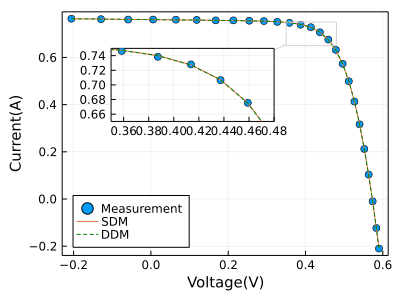

In [35]:
# continue the plot `p_RT`
plot!(p_RT, data_RT[:, 1], I_RT_DDM; label="DDM", linestyle=:dash, linecolor=:green)
plot!(p_RT; legend=:bottomleft, xlabel="Voltage(V)", ylabel="Current(A)", framestyle=:box)
lens!(p_RT, [0.35, 0.48], [0.65, 0.75], inset=(1, bbox(0.15, 0.15, 0.5, 0.3)), framestyle=:box)
savefig(p_RT, joinpath(img_dir, "DE_RT.pdf"))
p_RT  # display it here

- RMSE statistics

In [36]:
println("RMSE statistics in $ntrials runs (DDM + RTC France):")
measure_rmse_stats(model_ddm, data_RT, T_RT, bounds_RT_ddm, np, F, Cr, G_ddm)

RMSE statistics in 30 runs (DDM + RTC France):


Dict{Symbol, Float64} with 4 entries:
  :max  => 0.000986022
  :std  => 8.963e-7
  :mean => 0.000982727
  :min  => 0.000982485

- Measure average runtime

In [37]:
println("Measure the running time (DDM + RTC France):")
@benchmark begin
    de = StdDE(np, bounds_RT_ddm, StdOptions(F, Cr); senses=-1)
    evolve!(de, evaluator, G_ddm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (DDM + RTC France):


BenchmarkTools.Trial: 30 samples with 1 evaluation.
 Range (min … max):  814.105 ms …    1.216 s  ┊ GC (min … max): 5.36% … 4.46%
 Time  (median):     889.930 ms               ┊ GC (median):    5.51%
 Time  (mean ± σ):   919.281 ms ± 116.029 ms  ┊ GC (mean ± σ):  5.72% ± 0.55%

  █▄▁ ▁  ▁   ▁ ▄  ▁                                              
  ███▁█▁▁█▁▁▆█▁█▆▆█▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▆▁▆▁▁▆▁▁▆▁▁▁▁▁▁▁▁▆ ▁
  814 ms           Histogram: frequency by time          1.22 s <

 Memory estimate: 519.77 MiB, allocs estimate: 31340365.

### Photowatt-PWP201

In [38]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_PW, (V, I) -> model_ddm(V, I, θ..., T_PW));

- A typical run

In [39]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_PW_ddm, StdOptions(F, Cr); senses=-1)  # minimization
evolve!(de, evaluator, G_ddm; stats=[:best, :std])

gen  	best      	std       	
0    	2.30041e+02	Inf       	
1    	1.34378e+01	3.19873e+52	
2    	1.16159e+01	3.19873e+52	
3    	1.35936e+00	2.47734e+33	
4    	1.35936e+00	2.14108e+08	
5    	1.35936e+00	1.78306e+07	
6    	5.60660e-01	3.42742e+05	
7    	5.60660e-01	2.09124e+02	
8    	2.41067e-01	6.11527e+01	
9    	2.41067e-01	4.74733e+01	
10   	2.41067e-01	8.82196e+00	
11   	1.17836e-01	4.63670e+00	
12   	1.17836e-01	4.65714e+00	
13   	1.45106e-02	1.92859e+00	
14   	1.45106e-02	6.70224e-01	
15   	1.45106e-02	5.02968e-01	
16   	1.45106e-02	3.33883e-01	
17   	1.45106e-02	2.47144e-01	
18   	1.45106e-02	2.42610e-01	
19   	1.45106e-02	2.14325e-01	
20   	1.45106e-02	1.81809e-01	
21   	1.45106e-02	1.77945e-01	
22   	1.45106e-02	1.57321e-01	
23   	1.15270e-02	1.07343e-01	
24   	1.15270e-02	9.86616e-02	
25   	1.15270e-02	9.06648e-02	
26   	6.82530e-03	5.72503e-02	
27   	6.82530e-03	5.68188e-02	
28   	6.82530e-03	4.58059e-02	
29   	5.89165e-03	3.50758e-02	
30   	4.77296e-03	2.88310e-02	
31   	4.772

0×0 Matrix{Float64}

In [40]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
@printf("sse = %e\n", best_sse)
best_rmse = sqrt(best_sse / size(data_PW, 1))
@printf("Min RMSE (DDM + Photowatt-PWP201) = %.5e", best_rmse)

sse = 1.470247e-04
Min RMSE (DDM + Photowatt-PWP201) = 2.42507e-03

In [41]:
println("Best parameter values (DDM + Photowatt-PWP201):")
best = best_individual(de)

Best parameter values (DDM + Photowatt-PWP201):


7-element Vector{Float64}:
   1.0305142983163214
   0.009811361202764433
   3.4724518695030833
  48.64281805992416
  48.64283525732562
   1.2012710019514121
 981.9823987416182

- Visualization

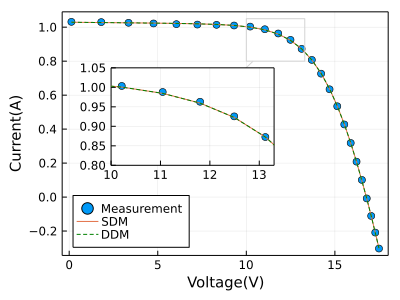

In [42]:
I_PW_DDM = [model_ddm(V, I, best..., T_PW) for (V, I) in eachrow(data_PW)];
plot!(p_PW, data_PW[:, 1], I_PW_DDM; label="DDM", linestyle=:dash, linecolor=:green)
plot!(p_PW; legend=:bottomleft, xlabel="Voltage(V)", ylabel="Current(A)", framestyle=:box, labelfontsize=10)
lens!(p_PW, [10, 13.3], [0.8, 1.05], inset=(1, bbox(0.15, 0.23, 0.5, 0.4)), framestyle=:box)
savefig(p_PW, joinpath(img_dir, "DE_PW.pdf"))
p_PW # also display here

- RMSE statistics

In [43]:
println("RMSE statistics in $ntrials runs (DDM + Photowatt-PWP201):")
measure_rmse_stats(model_ddm, data_PW, T_PW, bounds_PW_ddm, np, F, Cr, G_ddm)

RMSE statistics in 30 runs (DDM + Photowatt-PWP201):


Dict{Symbol, Float64} with 4 entries:
  :max  => 0.00242507
  :std  => 2.73556e-17
  :mean => 0.00242507
  :min  => 0.00242507

- Measure average runtime

In [44]:
println("Measure the running time (DDM + Photowatt-PWP201):")
@benchmark begin
    de = StdDE(np, bounds_PW_ddm, StdOptions(F, Cr); senses=-1)
    evolve!(de, evaluator, G_ddm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (DDM + Photowatt-PWP201):


BenchmarkTools.Trial: 30 samples with 1 evaluation.
 Range (min … max):  785.853 ms …    1.195 s  ┊ GC (min … max): 5.58% … 7.75%
 Time  (median):     902.010 ms               ┊ GC (median):    5.56%
 Time  (mean ± σ):   938.699 ms ± 115.394 ms  ┊ GC (mean ± σ):  5.86% ± 0.90%

  ▁  ▁  ███▁   ▁ ███▁▁  ▁ ▁█       ▁▁  ▁      ▁      ▁    ▁  ▁▁  
  █▁▁█▁▁████▁▁▁█▁█████▁▁█▁██▁▁▁▁▁▁▁██▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁█▁▁██ ▁
  786 ms           Histogram: frequency by time           1.2 s <

 Memory estimate: 499.89 MiB, allocs estimate: 30138815.